# Introduction
Here we are going to build neural network class such that we can actually train a model using our Value class.

# Libraries

In [1]:
import sys
sys.path.append("../../modules/Micrograd/")
from drawdot import draw_dot

In [2]:
###NN###
import random
from __future__ import annotations
from value import Value

# Module Class
This class has common functionality that will be used for all our other classes. It just has two functionalities: 1. It can take all parameters and set their gradients to zero, 2. It can return the parameters.

In [3]:
###NN###
class Module:

    def zero_grad(self):
        """
        Description:
            Sets the gradients of alle parameters to zero
        """
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        """
        Description:
            Returns the parameters
        """
        return []

In [4]:
# Testing functionality
m = Module()
m.zero_grad()
m.parameters()

[]

# Neuron Class
The **Neuron Class** lets you create a neuron with a random weight for each input value.

In [5]:
###NN###
class Neuron(Module):

    def __init__(self, nin: int, nonlin: bool = False) -> Neuron:
        """
        Description:
            Creates a neuron with nin weights.
        Inputs:
            nin: How many paramters the neuron should have
            nonlin: Whether a non-linear activation should be applied
        """
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, xs: list) -> Value:
        """
        Description:
            Given a list of xs the forward pass is executed
        Inputs:
            xs: A list of x-values
        Outputs:
            The calculated forward pass value
        """
        act = sum((wi*xi for wi,xi in zip(self.w, xs)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        """
        Description:
            Returns a list of parameters as well as the bias
        Outputs:
            The neuron parameters and bias
        """
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

In [6]:
# Initializing Neuron with four parameters
n = Neuron(4)

In [7]:
# Forward Pass
n([1,2,3,4])

Value(data=2.5125410377087602, grad=0.0)

# Layer Class
This class lets you create a layer of neurons.

In [8]:
###NN###
class Layer(Module):

    def __init__(self, nin, nout, **kwargs) -> Layer:
        """
        Description:
            Creates a layer (list of neurons).
        Inputs:
            nin: Neuron dimensionality
            nout: Number of neurons in layer
        """
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, xs) -> Value:
        """
        Description:
            Calculates the output for each neuron with 
            the given input values
        Inputs:    
            xs: Input values
        Outputs:
            The calculated forward pass value
        """
        out = [n(xs) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self) -> list:
        """
        Description:
            Returns a list of all parameters in the layer
        Ouputs:
            List of parameters
        """
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

In [9]:
# Creating a layer
l = Layer(4, 5)

In [10]:
# Calculating outputs for each neuron in the layer
l([1,2,3,4])

[Value(data=4.673086642789585, grad=0.0),
 Value(data=1.1342983531928168, grad=0.0),
 Value(data=3.131392926669135, grad=0.0),
 Value(data=-1.273832670661349, grad=0.0),
 Value(data=0.9794471288708748, grad=0.0)]

# Multi-Layer Percepton Class

In [11]:
###NN###
class MLP(Module):

    def __init__(self, nin: int, nouts: list) -> MLP:
        """
        Description:
            The multi-layer perceptron feeds the outputs of one 
            layer into the next. Here a list of layers is added 
            to the MLP object.
        Inputs:
            nin: Number of inputs to MLP
            nouts: List of outputs for each layer            
        """
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, xs: list) -> list | Value:
        """
        Description:
            Give inputs it calculates the MLP output via 
            a forward pass.
        Inputs:
            xs: Input values
        Outputs:
            The number af values given by the last layer
        """
        for layer in self.layers:
            xs = layer(xs)
        return xs

    def parameters(self):
        """
        Description:
            Returns a list of all parameters in the layer
        Ouputs:
            List of parameters
        """
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [12]:
# Creating Multi-layer perceptron
mlp = MLP(3,[4,4,1])

In [13]:
# Running af forward pass
mlp([1,2,3])

Value(data=-1.3667599790846432, grad=0.0)

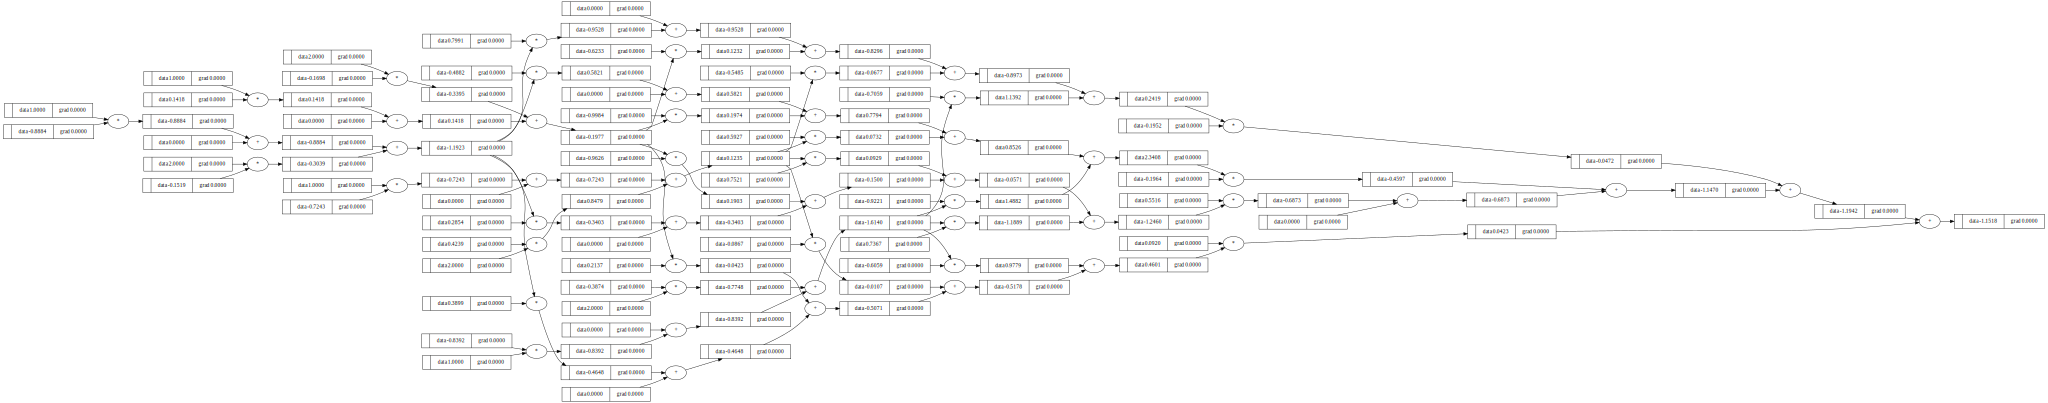

In [14]:
# Drawing Expression Tree
draw_dot(mlp([1,2]))

# Walking through a Neural Network
Here we have some inputs and desired outputs, and go through how to make predictions and how to evaluate how good the predictions are (loss).

In [15]:
# Inputs
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]

In [16]:
# Desired outputs
ys = [1.0,-1.0,-1.0,1.0]

In [17]:
# Create a MLP
mlp = MLP(3,[4,4,1])

In [18]:
# Getting initial predicitions
ypred = [mlp(x) for x in xs];ypred

[Value(data=-1.3399493888285028, grad=0.0),
 Value(data=-0.23400492697399566, grad=0.0),
 Value(data=-1.0127582876218426, grad=0.0),
 Value(data=-0.20494410394786947, grad=0.0)]

We want to calculate how much off the predictions are, we want to calculate the gradients of the network, and finally update the weights of the network. If we do this iteratively we should get close to the desired output.

In [19]:
# Calculating the loss
loss = sum([(y - ypred)**2 for y, ypred in zip(ys, ypred)]);loss

Value(data=7.514164661720772, grad=0.0)

In [20]:
# Checking out one gradient
mlp.layers[0].neurons[0].w[0]

Value(data=0.04781189675391184, grad=0.0)

In [23]:
# Running a backwards pass
loss.backward()

In [24]:
# Checking out one gradient
mlp.layers[0].neurons[0].w[0]

Value(data=0.04781189675391184, grad=1.0784821073663793)

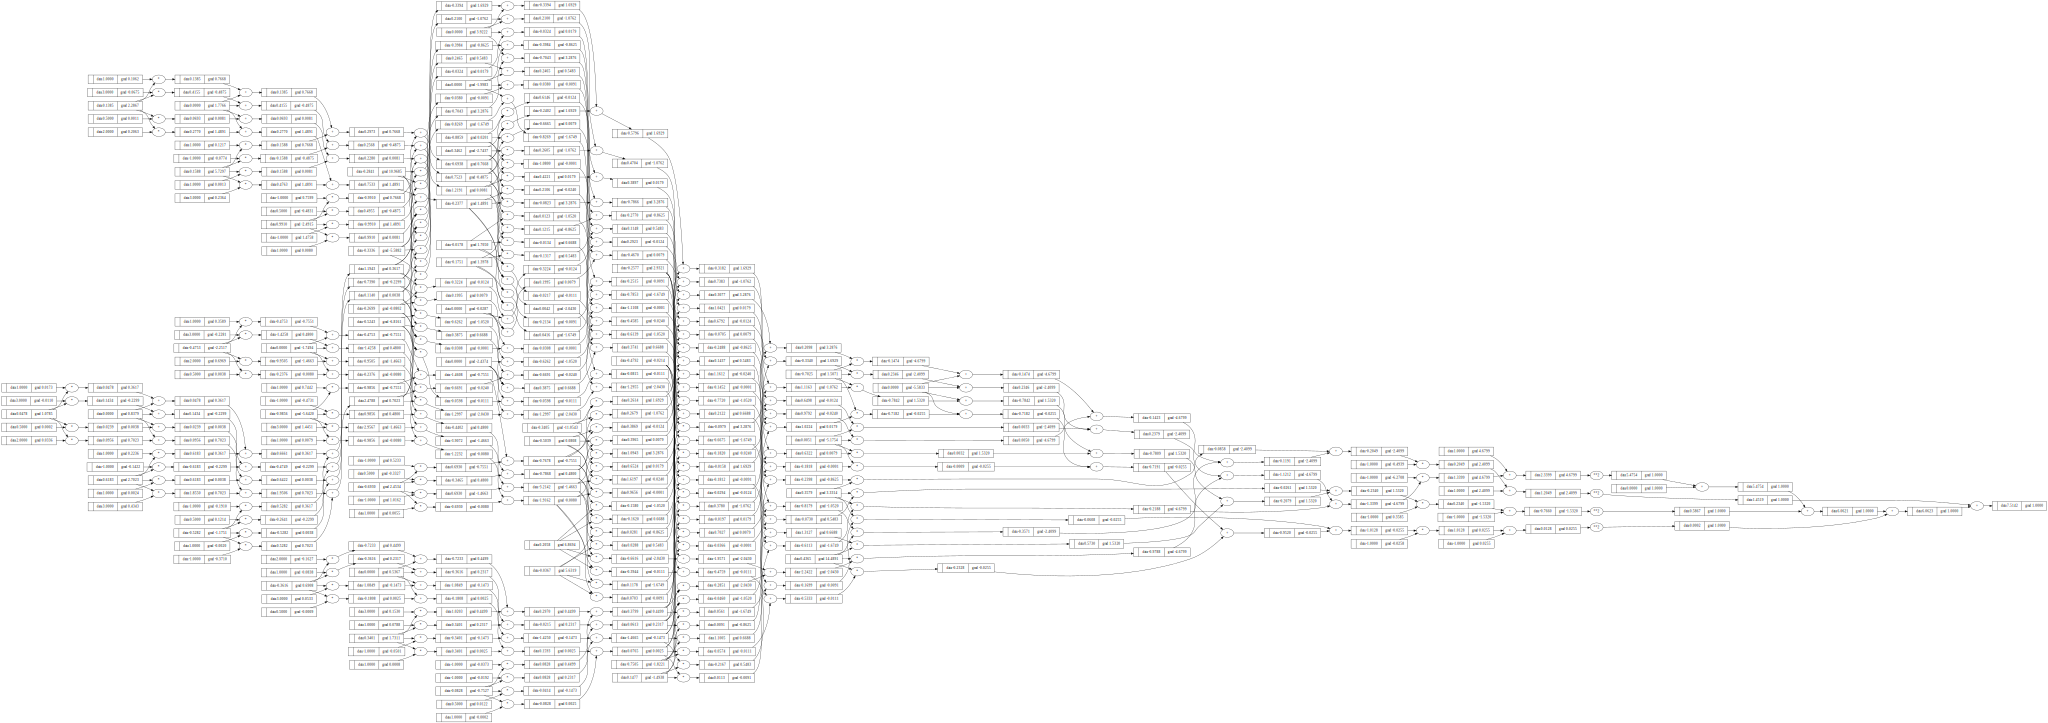

In [25]:
# Looking at the full expression graph
draw_dot(loss)

### Training a Neural Network
Now that we have investigated how the forward pass, the loss and the backward pass are calculated, we want to wrap it all in some code for training a neural network. That is we want to automatically: 1. Calculate forward pass, 2. Calculate loss, 3. Calculate backward pass (gradients), 4. Adjust weights, 5. Repeat. We want to continue iterating untill our loss is significantly low.

In [46]:
# How many times to go through all data
epochs = 50

In [47]:
# Learning rate (how much to adjust weights by)
lr = 0.01

In [48]:
# Creating a neural net
nn = MLP(3,[4,4,1])

In [49]:
for i in range(epochs):
    # Forward pass
    ypred = [nn(x) for x in xs]
    loss = sum([(y - ypred)**2 for y, ypred in zip(ys, ypred)]);print(loss)
    
    # Backward pass
    loss.backward()
    
    # Adjusting weights (gradient descend)
    for p in nn.parameters():
        p.data += -lr * p.grad

    # Resetting gradients to zero
    nn.zero_grad()

Value(data=38.82701312162381, grad=0.0)
Value(data=12.06874176430168, grad=0.0)
Value(data=2.3797974263017565, grad=0.0)
Value(data=1.584557283063087, grad=0.0)
Value(data=1.1565048095239483, grad=0.0)
Value(data=0.8437592560474596, grad=0.0)
Value(data=0.6215635690220943, grad=0.0)
Value(data=0.47278577555965684, grad=0.0)
Value(data=0.37617951057494403, grad=0.0)
Value(data=0.3122046776098967, grad=0.0)
Value(data=0.2668604813154224, grad=0.0)
Value(data=0.23178877841922949, grad=0.0)
Value(data=0.2026164612261181, grad=0.0)
Value(data=0.17725071569148876, grad=0.0)
Value(data=0.15473370762989017, grad=0.0)
Value(data=0.1346176936430553, grad=0.0)
Value(data=0.11666426501961497, grad=0.0)
Value(data=0.10071152771024391, grad=0.0)
Value(data=0.08661976473950157, grad=0.0)
Value(data=0.07425155770718059, grad=0.0)
Value(data=0.0634663933819796, grad=0.0)
Value(data=0.0541210668191693, grad=0.0)
Value(data=0.04607215889751544, grad=0.0)
Value(data=0.03917898824431179, grad=0.0)
Value(da

### Examining the predictions
We should stop the training when the loss no longer decreases. Now it is time to evaluated the predictions!

In [50]:
# Desired values
ys

[1.0, -1.0, -1.0, 1.0]

In [53]:
# Predicted values
ypred = [nn(x) for x in xs];ypred

[Value(data=1.0203883529688924, grad=0.0),
 Value(data=-0.998606439715476, grad=0.0),
 Value(data=-1.0101499707990087, grad=0.0),
 Value(data=0.9595983731345163, grad=0.0)]

Not bad!

# Writing Cells to Module
Here we write the Value class to a module by labeling the cell with ###NN###.

In [54]:
!python3.10 ../../helpers/ipynb_to_py.py 4.\ Neural\ Network\ Module.ipynb "###NN###" ../../modules/Micrograd/nn.py

INFO: Cells with label ###NN### extracted from 4. Neural Network Module.ipynb
